In [3]:
import pandas as pd

# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('rsa_stats.csv')

# Exibir as primeiras linhas do DataFrame
df.head()

,Algoritmo,tamanho,index,tempo_incrypt,tempo_decrypt
0,RSA,2,1,764.700000,2425.799999
1,RSA,2,2,135.300001,1609.300001
2,RSA,2,3,123.400001,903.800001
3,RSA,2,4,90.599999,895.800000
4,RSA,2,5,128.000001,1214.000000


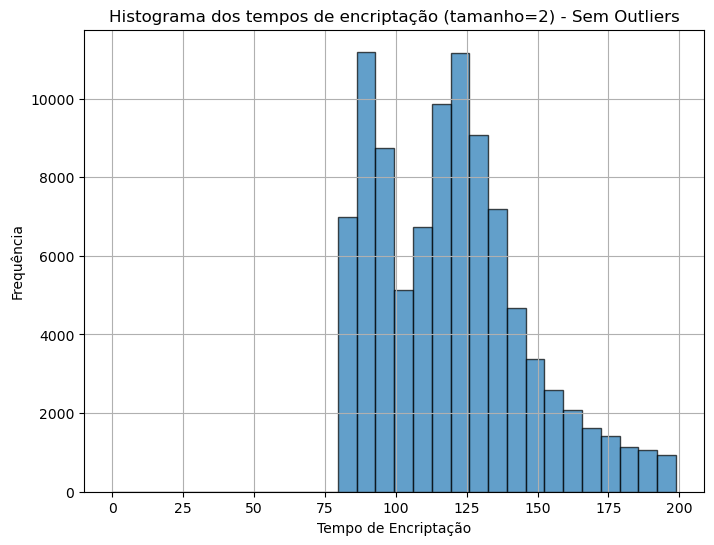

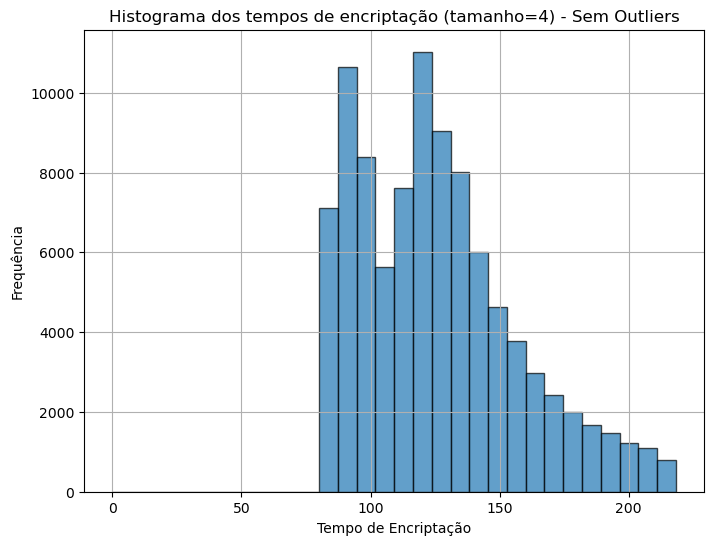

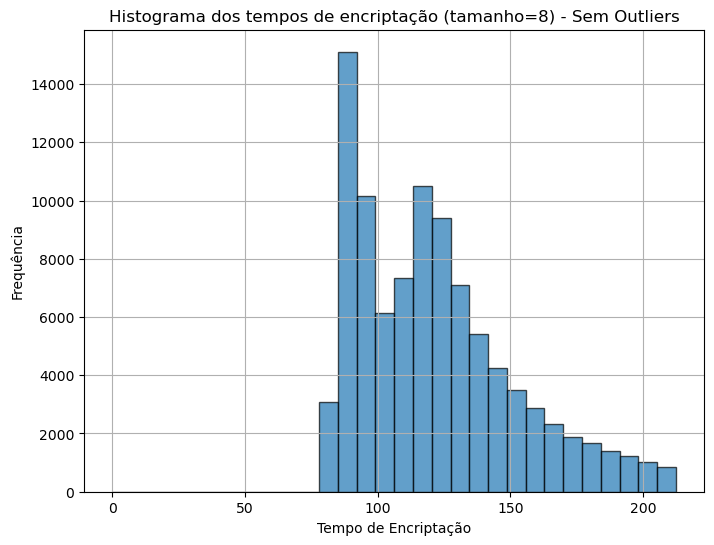

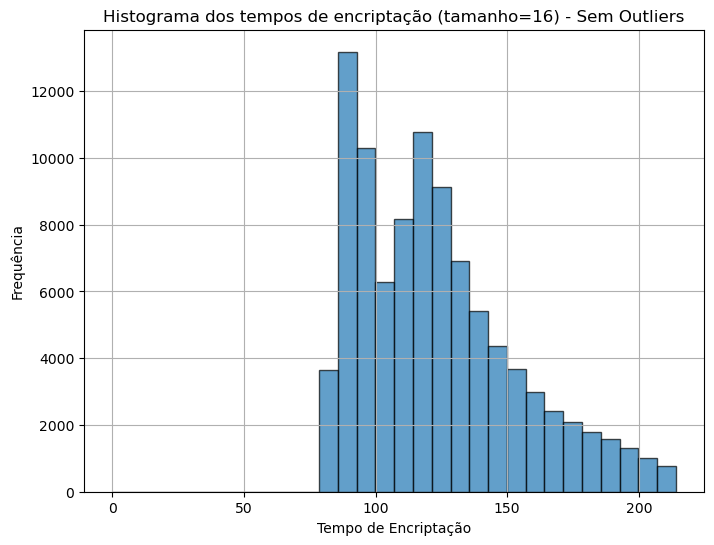

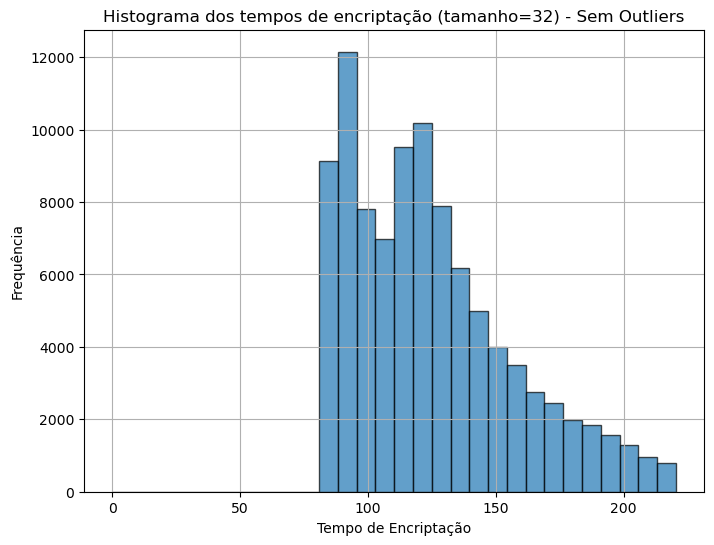

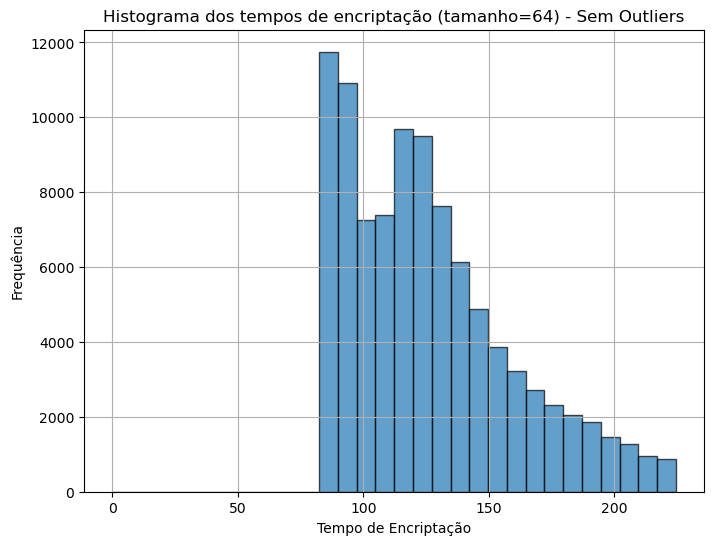

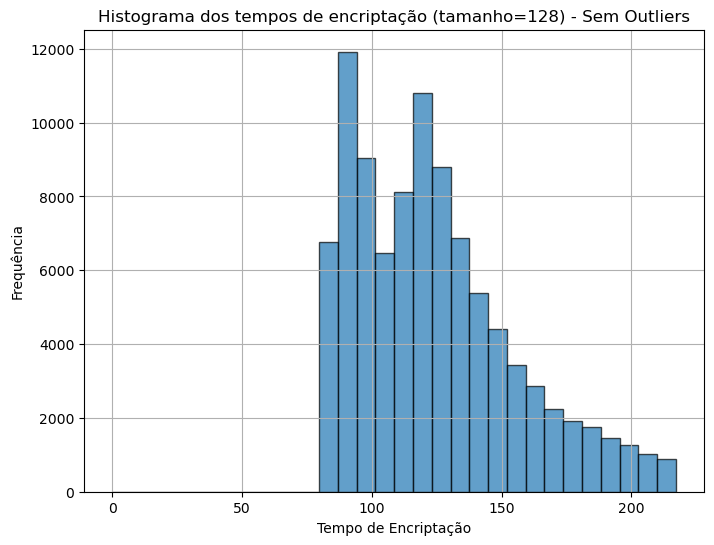

In [7]:
# Criar histogramas dos tempos de encriptação para cada tamanho, ignorando outliers
for tamanho in tamanhos_unicos:
    subset = df[df['tamanho'] == tamanho]
    
    # Calcular os limites do IQR
    Q1 = subset['tempo_incrypt'].quantile(0.25)
    Q3 = subset['tempo_incrypt'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar os dados para ignorar outliers
    subset_filtered = subset[(subset['tempo_incrypt'] >= lower_bound) & (subset['tempo_incrypt'] <= upper_bound)]
    
    # Plotar o histograma
    plt.figure(figsize=(8, 6))
    plt.hist(subset_filtered['tempo_incrypt'], bins=30, alpha=0.7, edgecolor='black', range=(0, subset_filtered['tempo_incrypt'].max()))
    plt.title(f'Histograma dos tempos de encriptação (tamanho={tamanho}) - Sem Outliers')
    plt.xlabel('Tempo de Encriptação')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()
